In [1]:
import random
import math
import numpy as np
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as nnf

from util import load_Cifar10

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
class ConvEncoder(nn.Module):
    def __init__(self, input_channels, base_channels, num_layers):
        """
        Args:
            input_channels (int): number of channels in the input image (e.g., 1 for grayscale, 3 for RGB).
            base_channels (int): number of filters in the first conv layer.
            num_layers (int): total number of conv layers.
        """
        super(ConvEncoder, self).__init__()
        layers = []
        in_channels = input_channels
        # We use a constant kernel size, stride, and padding.
        kernel_size = 3
        stride = 2  # downsampling by a factor of 2 each time
        padding = 1
        
        for i in range(num_layers):
            out_channels = base_channels * (2 ** i)
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                                    stride=stride, padding=padding))
            layers.append(nn.ReLU())
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)

class ConvDecoder(nn.Module):
    def __init__(self, output_channels, base_channels, num_layers):
        """
        Args:
            output_channels (int): number of channels in the output image.
            base_channels (int): should match the encoder's base_channels.
            num_layers (int): total number of conv transpose layers.
        """
        super(ConvDecoder, self).__init__()
        layers = []
        # Start with the number of channels at the bottleneck (last encoder layer)
        in_channels = base_channels * (2 ** (num_layers - 1))
        kernel_size = 3
        stride = 2  # upsampling by a factor of 2 each time
        padding = 1
        output_padding = 1  # usually needed to exactly invert the spatial dimension reduction

        # Reverse the process of the encoder.
        for i in range(num_layers +1, 0, -1):
            out_channels = base_channels * (2 ** (i - 1))
            layers.append(nn.ConvTranspose2d(in_channels, out_channels,
                                             kernel_size=kernel_size, stride=stride,
                                             padding=padding, output_padding=output_padding))
            layers.append(nn.ReLU())
            in_channels = out_channels

        # Final layer to get back to the desired output channels.
        layers.append(nn.ConvTranspose2d(in_channels, output_channels,
                                         kernel_size=kernel_size, stride=stride,
                                         padding=padding, output_padding=output_padding))
        
        self.decoder = nn.Sequential(*layers)
        

    def forward(self, x):
        return self.decoder(x)

class ConvAutoencoder(nn.Module):
    def __init__(self, input_channels, output_channels, base_channels, num_layers):
        super(ConvAutoencoder, self).__init__()
        self.encoder = ConvEncoder(input_channels, base_channels, num_layers)
        self.decoder = ConvDecoder(output_channels, base_channels, num_layers)  
        self.combiner = nn.Conv2d(output_channels*2, output_channels, kernel_size=1, stride=1, padding=0)
        self.loss = []
    def forward(self, x_lr, x_lr_up):
        latent = self.encoder(x_lr)
        output = self.decoder(latent)
        reconstruction = nnf.sigmoid(self.combiner(torch.cat((output, x_lr_up), 1)))
        return reconstruction

In [3]:
x_dim = 32
channels = 3

scale_factor = 2
x_inp_dim  = int(x_dim / scale_factor)


hidden_dim = 512

lr = 1e-4
epochs = 1000
batch_size = 1024

train_dataset, test_dataset, train_loader, test_loader, classes = load_Cifar10(batch_size)
num_train_data = len(train_dataset)

In [4]:
model = ConvAutoencoder(input_channels=3, output_channels=3, base_channels=32, num_layers=2).to(DEVICE)

# from torchsummary import summary
# summary(model, (3, 8, 8))

from torchvision import models

In [5]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

# class PerceptualLoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         vgg = models.vgg16(pretrained=True).features[:16]  # Use first layers
#         for param in vgg.parameters():
#             param.requires_grad = False  # Freeze VGG weights
#         self.vgg = vgg

#     def forward(self, pred, target):
#         pred_features = self.vgg(pred)
#         target_features = self.vgg(target)
#         return nnf.mse_loss(pred_features, target_features)  # Feature-level loss
    
# perceptual_loss = PerceptualLoss().to(DEVICE)
# train the model
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x_inp = nnf.interpolate(x, size=(8, 8), mode='bicubic', align_corners=False)
        x_inp = x_inp.to(DEVICE)
        x_inp_high = nnf.interpolate(x_inp, size=(32, 32), mode='bicubic', align_corners=False)
        x_inp_high = x_inp_high.to(DEVICE)
        x = x.to(DEVICE)
        optimizer.zero_grad()

        x_hat = model.forward(x_inp, x_inp_high)

        #loss = criterion(x_hat_combined, x)
        loss = criterion(x_hat, x)
        overall_loss += loss.item() / num_train_data
        # backpropagation
        loss.backward()
        optimizer.step()
    # print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    model.loss.append(overall_loss)

Epoch [10/1000], Loss: 0.6094
Epoch [20/1000], Loss: 0.5978
Epoch [30/1000], Loss: 0.5985
Epoch [40/1000], Loss: 0.5932
Epoch [50/1000], Loss: 0.5897
Epoch [60/1000], Loss: 0.5893
Epoch [70/1000], Loss: 0.5859
Epoch [80/1000], Loss: 0.5858
Epoch [90/1000], Loss: 0.5812
Epoch [100/1000], Loss: 0.5807
Epoch [110/1000], Loss: 0.5787
Epoch [120/1000], Loss: 0.5793
Epoch [130/1000], Loss: 0.5860
Epoch [140/1000], Loss: 0.5823
Epoch [150/1000], Loss: 0.5788
Epoch [160/1000], Loss: 0.5802
Epoch [170/1000], Loss: 0.5783
Epoch [180/1000], Loss: 0.5765
Epoch [190/1000], Loss: 0.5746
Epoch [200/1000], Loss: 0.5812
Epoch [210/1000], Loss: 0.5750
Epoch [220/1000], Loss: 0.5785
Epoch [230/1000], Loss: 0.5789
Epoch [240/1000], Loss: 0.5757
Epoch [250/1000], Loss: 0.5751
Epoch [260/1000], Loss: 0.5748
Epoch [270/1000], Loss: 0.5784
Epoch [280/1000], Loss: 0.5805
Epoch [290/1000], Loss: 0.5764
Epoch [300/1000], Loss: 0.5772
Epoch [310/1000], Loss: 0.5799
Epoch [320/1000], Loss: 0.5749
Epoch [330/1000],

[]

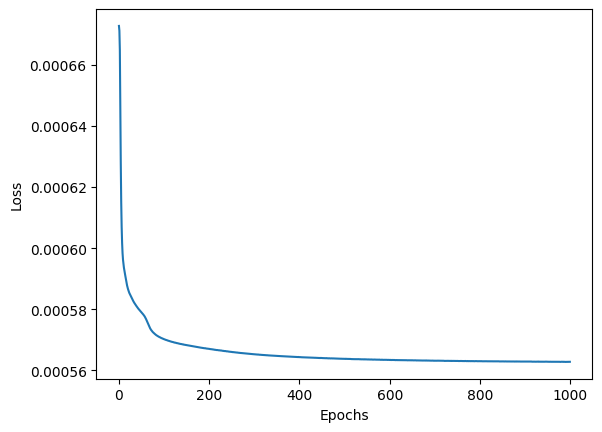

In [6]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [7]:
from tqdm import tqdm
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x_inp = nnf.interpolate(x, size=(8, 8), mode='bicubic', align_corners=False)
        x_inp = x_inp.to(DEVICE)
        x_inp_high = nnf.interpolate(x_inp, size=(32, 32), mode='bicubic', align_corners=False)
        x_inp_high = x_inp_high.to(DEVICE)
        x = x.to(DEVICE)

        x_hat = model(x_inp, x_inp_high)
        break

  0%|          | 0/10 [00:05<?, ?it/s]


In [8]:
def show_image(x, x_inp, x_hat, n):


    fig, axs = plt.subplots(4, n, figsize=(20, 6))
    for i in range(n):
        axs[0, i].imshow(x[i].permute(1, 2, 0).cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(x_inp[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(x_hat[i].permute(1, 2, 0).cpu().numpy())
        axs[2, i].axis('off')

        axs[3,i].imshow(x_inp_high[i].permute(1, 2, 0).cpu().numpy())
        axs[3, i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0056998087..0.95476586].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013254444..0.95699304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08439326..1.0167874].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10920823..1.033944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04707031..1.0005553].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0363125..1.063431].


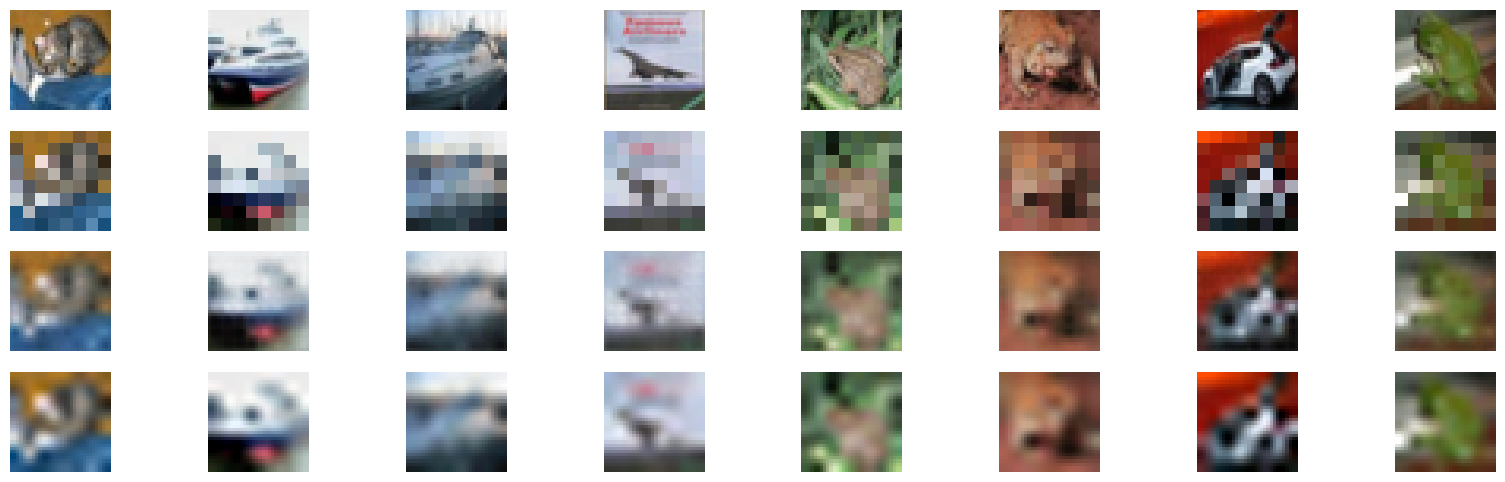

In [9]:
show_image(x, x_inp, x_hat, 8)

In [10]:
torch.save(model.state_dict(), "CIFAR_perceptual_all_conv_bce.pth")

In [14]:
import torch.nn.functional as F
from piq import psnr, ssim, brisque, LPIPS

def validation_scores(model, HR, LR):
    LR_up = nnf.interpolate(LR, size=(32, 32), mode='bicubic', align_corners=False)
    SR = model(LR, LR_up)

    psnr_val = psnr(HR, SR, data_range=1.0)

    ssim_val = ssim(HR, SR, data_range=1.0, reduction='none')

    lpips = LPIPS()
    lpips_val = lpips(HR, SR)

    brisque_val = brisque(SR)

    HR_downsampled = F.interpolate(HR, size=(LR.size(2), LR.size(3)), mode='bicubic', align_corners=False)
    HR_downsampled = (HR_downsampled - HR_downsampled.min()) / (HR_downsampled.max() - HR_downsampled.min())

    psnr_consistency_val = psnr(LR, HR_downsampled, data_range=1.0)

    mse_diversity_val = 0
    lpips_diversity_val = 0
    n_samples = 16
    for i in range(n_samples):
        LR_input = LR[i].unsqueeze(0)
        LR_input = LR_input.repeat(32, 1, 1, 1)
        LR_up = nnf.interpolate(LR_input, size=(32, 32), mode='bicubic', align_corners=False)
        HR_reference = HR[i].unsqueeze(0)
        HR_reference = HR_reference.repeat(32, 1, 1, 1)
        SR = model(LR_input, LR_up)
        mse_diversity_val += F.mse_loss(HR_reference, SR, reduction='mean')
        lpips_diversity_val += lpips(HR_reference, SR)
    mse_diversity_val /= n_samples
    lpips_diversity_val /= n_samples

    return psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val

In [15]:
x_inp = (x_inp - x_inp.min()) / (x_inp.max() - x_inp.min())
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, x, x_inp)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val.mean())
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

PSNR: tensor(19.7391, device='cuda:0', grad_fn=<MeanBackward1>)
SSIM: tensor(0.5558, device='cuda:0', grad_fn=<MeanBackward0>)
LPIPS: tensor(0.3639, device='cuda:0', grad_fn=<MeanBackward1>)
BRISQUE: tensor(72.3900, device='cuda:0', grad_fn=<MeanBackward1>)
PSNR Consistency: tensor(80., device='cuda:0')
MSE Diversity: tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>)
LPIPS Diversity: tensor(0.3740, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
BERECHNUNG DIVERSITY!